In [282]:
import pytz
import random
from tqdm import tqdm
from pathlib import Path
from datetime import datetime

import cv2
import numpy as np
from PIL import Image

import torch
from torch.utils.data import DataLoader

# from data.dark_face import DarkFaceDataset, collate_fn
from data.config import cfg
from data.widerface import WiderFaceDataset, collate_fn
from models.factory import build_net
from utils.augmentations import to_chw_bgr
from layers.modules import MultiBoxLoss

In [283]:
### Configurations
method = 'default'
num_classes = 2
num_samples = None
model_name = 'resnet50'
learning_rate = 1e-3
weight_decay = 5e-4
momentum = 0.9
gamma = 0.1
lr_steps = [80000, 100000, 120000]
negpos_ratio = 3
variance = [0.1, 0.2]
threshold = 0.5
device = torch.device('cpu')

batch_size = 16
num_epochs = 100
max_steps = 150000
save_freq = 5
num_workers = 8
pretrained_weights = 'weights/resnet50-19c8e357.pth'
# resume = 'runs/20250211_223733_DSDF-Wider-Face/weights/epoch_30.pth'
resume = None

In [284]:
def preprocess(image_path, img_mean, max_pixels):
    image = Image.open(image_path)
    if image.mode == 'L':
        image = image.convert('RGB')

    image = np.array(image)

    height, width, _ = image.shape

    max_im_shrink = np.sqrt(max_pixels / (image.shape[0] * image.shape[1]))
    image = cv2.resize(image, None, None, fx=max_im_shrink, fy=max_im_shrink, interpolation=cv2.INTER_LINEAR)
    # print(image.shape)
    # image = cv2.resize(image, (640, 640), interpolation=cv2.INTER_LINEAR)
    # image = image / 255.0

    x = to_chw_bgr(image)
    x = x.astype('float32')
    x -= img_mean
    x = x[[2, 1, 0], :, :]
    x = torch.from_numpy(x).unsqueeze(0)

    return x, width, height

In [ ]:
def infer(model, image_path, vis_image_path, img_mean, max_pixels, conf_thresh=0.5):
    x, img_width, img_height = preprocess(image_path, img_mean, max_pixels)
    model.eval()
    with torch.no_grad():
        output = model(x)
    scale = torch.Tensor([img_width, img_height, img_width, img_height])
    # image = cv2.imread(str(image_path))
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.imread(str(vis_image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # print(output.shape)
    # print(f"Number of objects above conf_thresh: {(output[0, :, :, 0] > conf_thresh).sum().item()}")

    for i in range(output.shape[1]):
        # i = 1
        j = 0
        while j < output.shape[2] and output[0, i, j, 0] > conf_thresh:
            pt = (output[0, i, j, 1:] * scale).cpu().numpy()
            score = output[0, i, j, 0].cpu().numpy()
            j += 1
            cv2.rectangle(image, (int(pt[0]), int(pt[1])), (int(pt[2]), int(pt[3])), (255, 0, 0), 2)

    return image

In [286]:
# weights_path = Path('runs/20250211_060036/epoch_80.pth')
weights_path = Path('runs/20250214_223548_DSDF-Ours-resnet-pretrained/weights/epoch_100.pt')
# save_root = 'submission'  # Root directory for saving results
# save_dir = weights_path.parent / save_root / Path(weights_path).stem  # Create a folder using weights name
# save_dir.mkdir(parents=True, exist_ok=True)

from models.DSFD_ours import DSFD, build_net_resnet

# model = build_net('test', num_classes, model_name)
model = build_net_resnet('test', num_classes, model_name)
model.load_state_dict(torch.load(weights_path, map_location='cpu')['model'])

/tmp/ipykernel_1055696/1950613783.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location='cpu')['model'])


<All keys matched successfully>

In [289]:
image_dir = Path('/home/ubuntu/data/DarkFace_Train_2021/Track1.2_testing_samples')
sci_image_dir = Path('/home/ubuntu/data/DarkFace_Train_2021/DarkFace_Test_SCI')
# image_dir = '/home/ubuntu/data/WiderFace/WIDER_val/images/0--Parade'
images = sorted(Path(image_dir).glob('*'))

/home/ubuntu/jaeha/DSFD.pytorch/models/DSFD_ours.py:309: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  return F.upsample(x, size=(H, W), mode='bilinear') * y
/home/ubuntu/jaeha/DSFD.pytorch/models/DSFD_ours.py:384: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors_pal1 = Variable(priorbox.forward(), volatile=True)
/home/ubuntu/jaeha/DSFD.pytorch/models/DSFD_ours.py:387: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors_pal2 = Variable(priorbox.forward(), volatile=True)


torch.Size([1, 2, 750, 5])
Number of objects above conf_thresh: 3


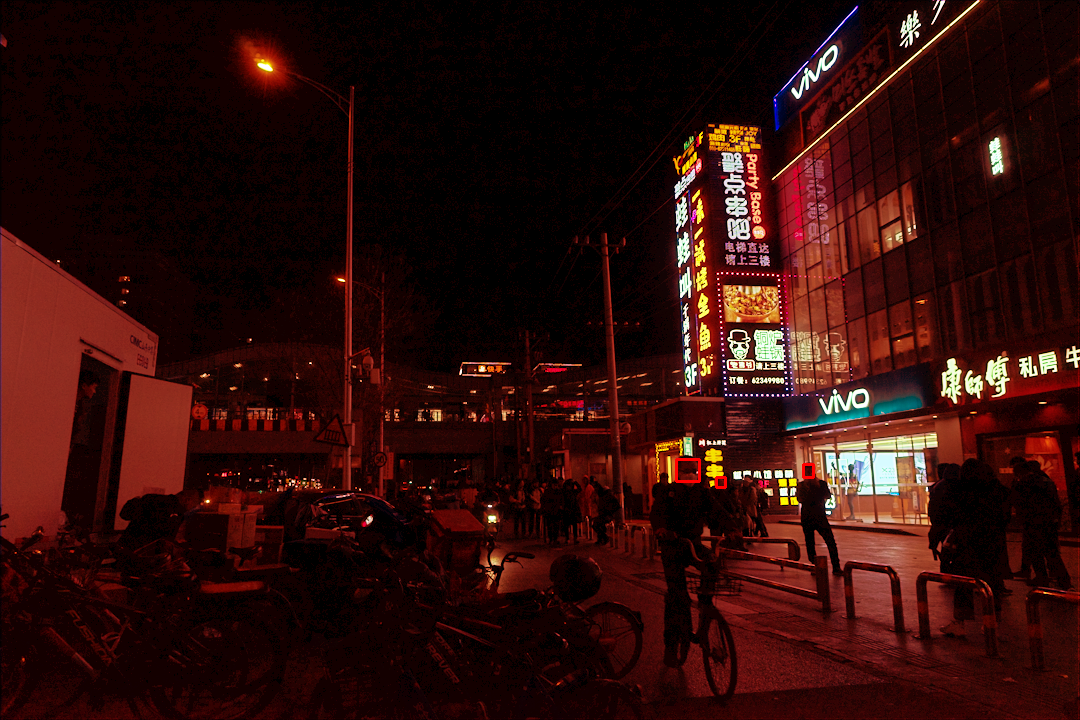

In [292]:
img_mean = np.array([104., 117., 123.])[:, np.newaxis, np.newaxis].astype('float32')
max_pixels = 1500 * 1000
conf_thresh = 0.25

random_image = random.choice(images)

results = infer(model, random_image, sci_image_dir / random_image.with_suffix('.jpg').name, img_mean, max_pixels, conf_thresh)
Image.fromarray(results)

In [ ]:
img_mean = np.array([104., 117., 123.])[:, np.newaxis, np.newaxis].astype('float32')
max_pixels = 1500 * 1000
conf_thresh = 0.25

results_dir = weights_path.parent.parent / 'results'
results_dir.mkdir(parents=True, exist_ok=True)

for image in tqdm(images):
    results = infer(model, image, sci_image_dir / image.with_suffix('.jpg').name, img_mean, max_pixels, conf_thresh)
    cv2.imwrite(str(results_dir / image.with_suffix('.jpg').name), cv2.cvtColor(results, cv2.COLOR_RGB2BGR))

  0%|          | 1/4000 [00:05<5:45:36,  5.19s/it]

torch.Size([1, 2, 750, 5])
Number of objects above conf_thresh: 7


  0%|          | 2/4000 [00:10<5:33:08,  5.00s/it]

torch.Size([1, 2, 750, 5])
Number of objects above conf_thresh: 2


  0%|          | 3/4000 [00:14<5:27:52,  4.92s/it]

torch.Size([1, 2, 750, 5])
Number of objects above conf_thresh: 8


  0%|          | 4/4000 [00:20<5:40:29,  5.11s/it]

torch.Size([1, 2, 750, 5])
Number of objects above conf_thresh: 3


  0%|          | 5/4000 [00:25<5:40:07,  5.11s/it]

torch.Size([1, 2, 750, 5])
Number of objects above conf_thresh: 1


  0%|          | 6/4000 [00:31<5:56:22,  5.35s/it]

torch.Size([1, 2, 750, 5])
Number of objects above conf_thresh: 2


  0%|          | 7/4000 [00:36<5:55:24,  5.34s/it]

torch.Size([1, 2, 750, 5])
Number of objects above conf_thresh: 3


  0%|          | 8/4000 [00:41<5:51:46,  5.29s/it]

torch.Size([1, 2, 750, 5])
Number of objects above conf_thresh: 7


In [181]:
### Configurations
method = 'default'
num_classes = 2
num_samples = None
model_name = 'resnet50'
learning_rate = 1e-3
weight_decay = 5e-4
momentum = 0.9
gamma = 0.1
lr_steps = [80000, 100000, 120000]
negpos_ratio = 3
variance = [0.1, 0.2]
threshold = 0.5
# device = torch.device('cpu')
device = torch.device('cuda:0')

batch_size = 1
num_epochs = 100
max_steps = 150000
save_freq = 5
num_workers = 2
pretrained_weights = 'weights/resnet50-19c8e357.pth'
# resume = 'runs/20250211_223733_DSDF-Wider-Face/weights/epoch_30.pth'
resume = None

In [182]:
from data.config import cfg
from data.widerface import WiderFaceDataset, collate_fn

val_dataset = WiderFaceDataset(
    cfg.FACE.VAL_FILE, mode='val'
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers
)

In [183]:
# weights_path = Path('runs/20250211_060036/epoch_80.pth')
weights_path = Path('weights/wider_face/epoch_100.pth')
# save_root = 'submission'  # Root directory for saving results
# save_dir = weights_path.parent / save_root / Path(weights_path).stem  # Create a folder using weights name
# save_dir.mkdir(parents=True, exist_ok=True)

model = build_net('test', num_classes, model_name)
model.load_state_dict(torch.load(weights_path, map_location='cpu')['model'])
model.to(device)
model.eval()

/tmp/ipykernel_1055696/3014275128.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location='cpu')['model'])


DSFD(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [184]:
from layers.functions import Detect

detect = Detect(
    num_classes=num_classes,
    top_k=cfg.TOP_K,
    nms_thresh=cfg.NMS_THRESH,
    conf_thresh=cfg.CONF_THRESH,
    variance=cfg.VARIANCE,
    nms_top_k=cfg.NMS_TOP_K
)

In [261]:
tbar = tqdm(val_loader, desc='Evaluating')
all_preds = [] # [1, 2, 750, 5] X K
all_targets = [] # [[N, 5], [N, 5], ...] X K
num_images = 10
for i, (images, targets) in enumerate(tbar):
    images = images.to(device)
    with torch.no_grad():
        preds = model(images)
    # confxyxy -> xyxyconf (swap)
    preds = preds[..., [1, 2, 3, 4, 0]]
    all_preds.append(preds.cpu()) # [1, 2, 750, 5]
    all_targets.append(targets) # [[N, 5], [N, 5], ...]
    if i == num_images:
        break
    # break

Evaluating:   0%|          | 0/3222 [00:00<?, ?it/s]/home/ubuntu/jaeha/DSFD.pytorch/models/DSFD_resnet.py:222: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  return F.upsample(x, size=(H, W), mode='bilinear') * y
/home/ubuntu/jaeha/DSFD.pytorch/models/DSFD_resnet.py:292: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors_pal1 = Variable(priorbox.forward(), volatile=True)
/home/ubuntu/jaeha/DSFD.pytorch/models/DSFD_resnet.py:295: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors_pal2 = Variable(priorbox.forward(), volatile=True)
Evaluating:   0%|          | 10/3222 [00:01<09:09,  5.85it/s]


In [262]:
all_preds[0].shape

torch.Size([1, 2, 750, 5])

In [263]:
import torch

def norm_score(org_pred_list):
    norm_pred_list = []
    max_score = torch.finfo(torch.float32).min
    min_score = torch.finfo(torch.float32).max

    for i in range(len(org_pred_list)):
        pred = org_pred_list[i]
        scores = pred[..., 4]
        max_score = max(max_score, scores.max())
        min_score = min(min_score, scores.min())

    for i in range(len(org_pred_list)):
        pred = org_pred_list[i]
        scores = pred[..., 4]
        if max_score != min_score:
            norm_scores = (scores - min_score) / (max_score - min_score)
        else:
            norm_scores = (scores - (min_score - 1))
        org_pred_list[i][..., 4] = norm_scores

    norm_pred_list = org_pred_list
    return norm_pred_list

In [264]:
def compute_iou(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    a: shape (N, 4) -> [[x1, y1, x2, y2],
                        [x1, y1, x2, y2],
                         ...
                       ]
    b: shape (4,)   -> [x1, y1, x2, y2]

    Returns:
        A 1D Tensor of size N, each element representing
        the IOU between one of the boxes in 'a' and 'b'.
    """
    # Calculate the top-left corner of the intersection area
    x1 = torch.max(a[:, 0], b[0])
    y1 = torch.max(a[:, 1], b[1])

    # Calculate the bottom-right corner of the intersection area
    x2 = torch.min(a[:, 2], b[2])
    y2 = torch.min(a[:, 3], b[3])

    # Compute width and height of the intersection area (+1 to match pixel-based bounding box convention)
    w = x2 - x1 + 1
    h = y2 - y1 + 1

    # Compute the area of the intersection
    inter = w * h

    # Compute the area of each box in 'a' and the box 'b' (+1 applied similarly)
    aarea = (a[:, 2] - a[:, 0] + 1) * (a[:, 3] - a[:, 1] + 1)
    barea = (b[2] - b[0] + 1) * (b[3] - b[1] + 1)

    # Calculate IOU = inter / (aarea + barea - inter)
    iou = inter / (aarea + barea - inter)

    # If intersection dimensions become zero or negative, set IOU to 0
    iou[w <= 0] = 0
    iou[h <= 0] = 0

    return iou

In [265]:
def eval_image(preds, targets, iou_thresh=0.5):
    pred_recall = torch.zeros((len(preds), 1))
    recall_list = torch.zeros((len(targets), 1))
    proposal_list = torch.ones((len(preds), 1))
    for i in range(len(preds)):
        overlap_list = compute_iou(targets, preds[i, :4])
        max_overlap, max_idx = overlap_list.max(dim=0)
        if max_overlap >= iou_thresh:
            recall_list[max_idx] = 1

        r_keep_index = torch.where(recall_list == 1)[0]
        pred_recall[i] = len(r_keep_index)

    return pred_recall, proposal_list

In [266]:
def image_pr_info(num_thresh, preds, proposal_list, pred_recall):
    """
    Compute image precision-recall information for a range of thresholds.

    Args:
        num_thresh (int): Number of thresholds.
        preds (torch.Tensor): Tensor containing prediction information (assumes the 5th column contains scores).
        proposal_list (torch.Tensor): Tensor indicating proposals (e.g., binary indicator).
        pred_recall (torch.Tensor): Tensor of cumulative recall values.

    Returns:
        torch.Tensor: A tensor of shape [num_thresh, 2] where:
                      - Column 0 stores the number of proposals.
                      - Column 1 stores the recall value corresponding to the threshold.
    """
    img_pr_info = torch.zeros((num_thresh, 2))
    for t in range(num_thresh):
        thresh = 1 - t / num_thresh
        mask = preds[:, 4] >= thresh
        indices = torch.nonzero(mask, as_tuple=True)[0]
        r_index = indices[-1].item() if indices.numel() > 0 else None
        if r_index is None:
            img_pr_info[t, 0] = 0.0
            img_pr_info[t, 1] = 0.0
        else:
            # Find indices in proposal_list[0:r_index+1] where the value is 1
            p_index = torch.nonzero(proposal_list[:r_index+1] == 1, as_tuple=True)[0]
            # Store the number of proposals in the first column
            img_pr_info[t, 0] = p_index.numel()
            # Store the corresponding recall value from pred_recall in the second column
            img_pr_info[t, 1] = pred_recall[r_index].item()

    return img_pr_info

In [267]:
import torch

def voc_ap(rec, prec):
    """
    Compute VOC Average Precision (AP) given recall and precision tensors.

    Args:
        rec (torch.Tensor): Tensor of recall values.
        prec (torch.Tensor): Tensor of precision values.

    Returns:
        float: Average Precision (AP) score.
    """
    # Append boundary values to recall and precision
    mrec = torch.cat((
        torch.tensor([0.], device=rec.device, dtype=rec.dtype),
        rec,
        torch.tensor([1.], device=rec.device, dtype=rec.dtype)
    ))
    mpre = torch.cat((
        torch.tensor([0.], device=prec.device, dtype=prec.dtype),
        prec,
        torch.tensor([0.], device=prec.device, dtype=prec.dtype)
    ))

    # Create the precision envelope (make precision non-increasing)
    for i in range(mpre.size(0) - 2, -1, -1):
        mpre[i] = torch.maximum(mpre[i], mpre[i + 1])

    # Identify indices where the recall value changes
    idx = torch.where(mrec[1:] != mrec[:-1])[0] + 1

    # Sum (delta recall) * precision at those indices to get AP
    ap = torch.sum((mrec[idx] - mrec[idx - 1]) * mpre[idx])
    return ap.item()

In [268]:
def voc_ap(rec, prec):
    """
    Compute VOC AP given recall and precision arrays.

    Args:
        rec (np.ndarray): Array of recall values.
        prec (np.ndarray): Array of precision values.

    Returns:
        float: Average Precision (AP) score.
    """
    # Append boundary values to recall and precision
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # Make the precision envelope (ensure precision is non-increasing)
    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i + 1])

    # Identify indices where recall changes
    idx = np.where(mrec[1:] != mrec[:-1])[0] + 1

    # Sum (\Delta recall) * precision at those indices to get AP
    ap = np.sum((mrec[idx] - mrec[idx - 1]) * mpre[idx])
    return ap

In [269]:
from tqdm import tqdm

iou_thresh = 0.5
num_thresh = 1000
num_faces = 0
img_pr_info_list = []
org_pr_curve = torch.zeros((num_thresh, 2))
norm_preds = norm_score(all_preds)
max_images = 10

# for preds, targets in zip(tqdm(norm_preds), all_targets):
for i, (preds, targets) in enumerate(zip(tqdm(norm_preds), all_targets)):
    if len(targets[0]) > 0:
        num_faces += len(targets[0])
        pred_recall, proposal_list = eval_image(preds[0, 1], targets[0], iou_thresh)
        img_pr_info_list.append(image_pr_info(num_thresh, preds[0, 1], proposal_list, pred_recall))
    if i == max_images:
        break

for i in range(len(img_pr_info_list)):
    org_pr_curve[:, 0] += img_pr_info_list[i][:, 0]
    org_pr_curve[:, 1] += img_pr_info_list[i][:, 1]

pr_curve = torch.zeros((num_thresh, 2))

for i in range(num_thresh):
    pr_curve[i, 0] = org_pr_curve[i, 1] / org_pr_curve[i, 0]
    pr_curve[i, 1] = org_pr_curve[i, 1] / num_faces

print(f"Number of faces: {num_faces}")

 91%|█████████ | 10/11 [00:02<00:00,  3.70it/s]

Number of faces: 501


Average Precision: 0.8939616057369641


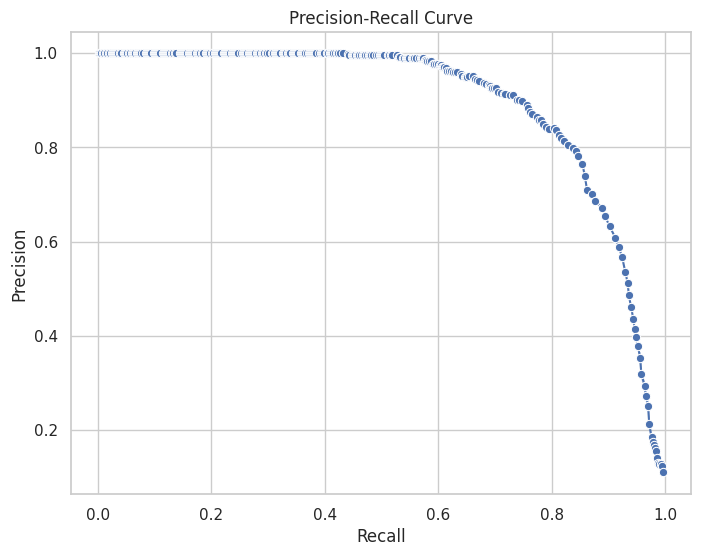

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pr_curve_np = pr_curve.detach().cpu().numpy() if pr_curve.is_cuda else pr_curve.numpy()

precision = pr_curve_np[:, 0]
recall = pr_curve_np[:, 1]

# Compute AP
ap = voc_ap(recall, precision)

print(f"Average Precision: {ap}")

df = pd.DataFrame({'Recall': recall, 'Precision': precision})

sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.lineplot(x='Recall', y='Precision', data=df, marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()